# **Using piecewise linear functions**

***piecewise_linear.ipynb***

Example that uses [problem.addpwlcons()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addpwlcons.html) and [xpress.pwl()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/xpress.pwl.html) to approximate a nonlinear univariate function.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

In this example, we approximate the nonlinear function $\sin(5x),  \forall x \in [0, 2/\pi]$ using $N$ points.

As a simple approximation, we work with breakpoints lying on the curve of the original nonlinear function, which are determined by the function value for a sample of specified $x$.

Start by importing the necessary packages and define a function that returns the breakpoints ($x$ values) and their corresponding $y$ values as lists for a specified $N$ and frequency value.

In [ ]:
import xpress as xp
import math
import numpy as np
import matplotlib.pyplot as plt

def create_segments(N, freq):
    """N: Number of breakpoints for an approximation with (N-1) segments"""
     
    step = (2 / math.pi) / (N - 1)                       # width of each segment = domain / (N-1)
    breakpoints = np.array([i * step for i in range(N)]) # x value of each breakpoint
    values = np.sin(freq * breakpoints)                  # value of the function at each breakpoint

    return breakpoints, values

## Approximation using *problem.addpwlcons()*

The [p.addpwlcons()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addpwlcons.html) function can be used for creating and directly adding piecewise linear constraints to a problem by passing **the coordinates of each breakpoint**. 

Each piecewise linear constraint $y = f(x)$ consists of an (input) column $x$, a resultant (output column) $y$ and a piecewise linear function $f$. The piecewise linear function $f$ is described by a number of breakpoints, which are given as combinations of $x$ (breakpoints) and $y$ (values).

An auxiliary variable $y$ is created to represent the approximated value for any given solution $x$. In our example, this variable is defined as the objective function **to be maximized**, but it could also be modeled via a transfer variable. The nonlinear function, as well as the approximated PWL function are then plotted.

FICO Xpress v9.5.1, Hyper, solve started 16:48:02, Feb 7, 2025
Heap usage: 387KB (peak 387KB, 85KB system)
Maximizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
         0 rows            2 cols            0 elements         0 entities
         1 pwlcons
Presolved problem has:
         0 rows            0 cols            0 elements         0 entities
Presolve finished in 0 seconds
Heap usage: 393KB (peak 404KB, 85KB system)
Will try to keep branch and bound tree memory usage below 23.2GB
Starting concurrent solve with dual (1 thread)

 Concurrent-Solve,   0s
            Dual        
    objective   dual inf
 D   .9878433   .0000000
                        
------- optimal --------
Concurrent statistics:
           Dual: 0 simplex iterations, 0.00s
Optimal solution found
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0    

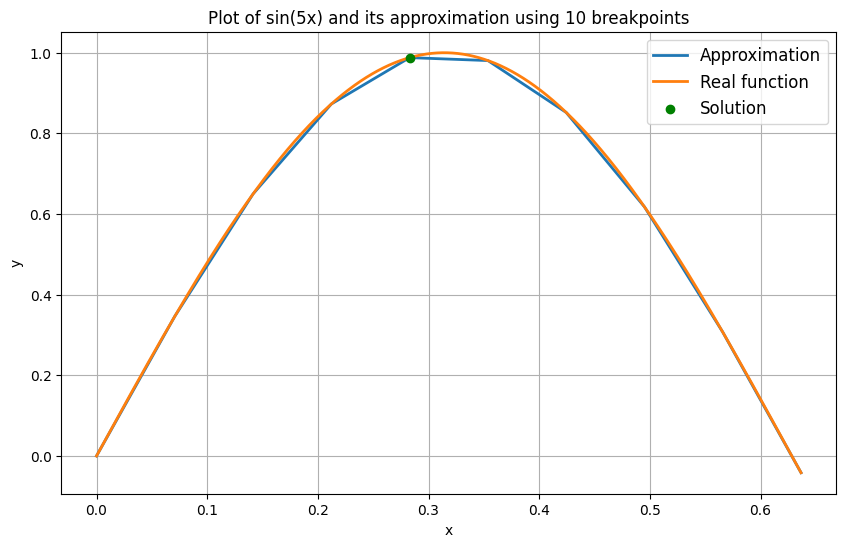

In [2]:
p = xp.problem()

x = p.addVariable()

N = 10                                          # number of breakpoints
freq = 5                                        # frequency
breakpoints, values = create_segments(N, freq)  # breakpoints and values at breakpoints

# Piecewise linear approximation using the p.addpwlcons() method
pw = p.addVariable()  # auxiliary variable to represent the 'resultant' array and set as objective to maximize

p.addpwlcons([x], [pw], [0], breakpoints, values) 

p.setObjective(pw, xp.maximize)

p.optimize()

print("Solution: x = ", p.getSolution(x))
print("Value of piecewise linear function:", xp.evaluate(pw, problem=p))
print("Objective function:", p.attributes.objval)

# High-resolution plot of the function for comparison
breakpoints_high, slopes_high = create_segments(10000, freq)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(breakpoints, values, label='Approximation', linewidth=2)
plt.plot(breakpoints_high, slopes_high, label='Real function', linewidth=2)
plt.scatter(p.getSolution(x), p.getSolution(pw), color='green', zorder=5, label='Solution')  # Add the point to the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Plot of sin({freq}x) and its approximation using {N} breakpoints')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Approximation using *xpress.pwl()*

Alternatively, you can use the [xpress.pwl()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/xpress.pwl.html) method, which returns a piecewise linear function over variable $x$, by taking a Python dictionary as an argument containing as:
  - keys: the intervals specified as two-elements tuples (must be pairwise disjoint, i.e., they must not overlap)
  - values: linear expressions in a variable. 

A piecewise linear function must use only one variable in all of the dictionary's values. Besides, all values in the dictionary must be either constants or linear functions.

In this case, besides the breakpoints and corresponding values, we calculate the values for the derivative of the initial function to **compute the slopes** to be used in the formulation of the function values for each interval.

*Note: the method p.addpwlcons() is better suited for cases where only the coordinates are known, while the xp.pwl() method is more intuitive when the slopes are known*

Original problem size
   linear:    1 rows, 2 columns, 1 linear coefficients
   nonlinear: 1 coefficients, 39 tokens
              0 minmax          1 pwl         0 ufun
Nonlinear presolve
   converted 1 PWL to optimizer MIP constructs
   linearizations will be solved as a MIP
   converted 1 formulas to linear constraints
   converted objective transfer row to linear objective
   linear presolve removed 2 rows, 1 columns, 20 linear coefficients
Presolved problem size
   linear:    21 rows, 38 columns, 105 linear coefficients
Problem is nonlinear presolved
Maximizing problem using Xpress-Optimizer
FICO Xpress v9.5.1, Hyper, solve started 16:53:03, Feb 7, 2025
Heap usage: 2463KB (peak 2490KB, 307KB system)
Maximizing MILP noname using up to 20 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
IFCHECKCONVEXITY = 0
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
        21 rows           38 cols          105 elements        17 enti

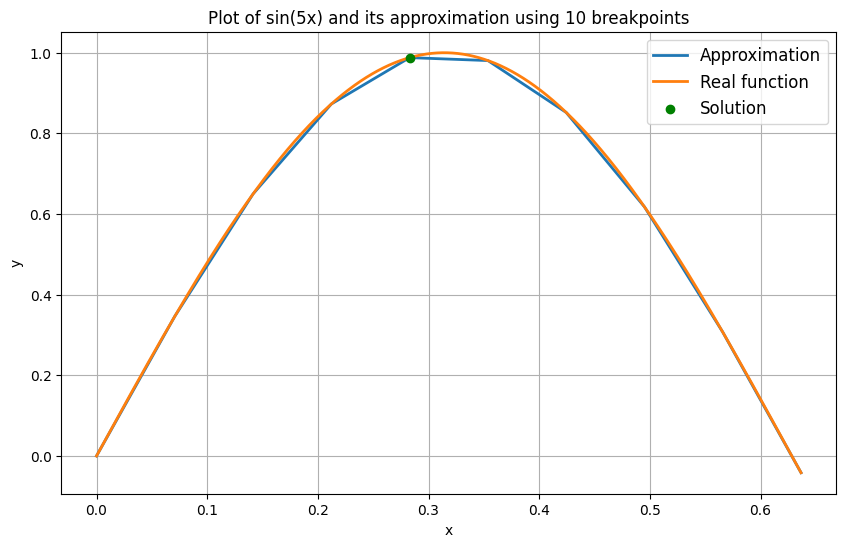

In [ ]:
p = xp.problem()  # create a problem and add variable x

x = p.addVariable(ub=4)

N = 10       # number of breakpoints
freq = 5     # frequency
breakpoints, values = create_segments(N, freq)  # breakpoints and values of the function
slopes = freq * np.cos(freq * breakpoints)      # derivatives

# Piecewise linear, discontinuous function over N points: over the
# i-th interval, the function is equal to v[i] + s[i] * (y - b[i])
# where v, s, b are value, slope, and breakpoint.
pw = xp.pwl({(breakpoints[i], breakpoints[i+1]):
            values[i] + slopes[i] * (x - breakpoints[i]) for i in range(N - 1)})

#p.addConstraint(1 >= pw)
p.setObjective(pw, xp.maximize)

p.optimize()

print("Solution: x = ", p.getSolution(x))
print("Value of piecewise linear function:", xp.evaluate(pw, problem=p))
print("Objective function:", p.attributes.objval)

# High-resolution plot of the function for comparison
breakpoints1, slopes1 = create_segments(10000, freq)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(breakpoints, values, label='Approximation', linewidth=2)
plt.plot(breakpoints1, slopes1, label='Real function', linewidth=2)
plt.scatter(p.getSolution(x), p.getSolution(pw), color='green', zorder=5, label='Solution')  # Add the point to the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Plot of sin({freq}x) and its approximation using {N} breakpoints')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()